In [1]:
import os
import time

from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2

import torch
from torch import nn, optim
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F


In [2]:
DATASET_FILEPATH = Path('/kaggle/input/leapgestrecog/leapGestRecog/')
IMG_SIZE = 256
RANDOM_STATE = 42

Подготовка датасета

In [7]:
import re

def gest_label_encoding(gest):
    code = re.findall('^\d*', gest)[0]
    return int(code)-1

def make_df_from_files(parent_dir_path=DATASET_FILEPATH):
    result = list()
    for person in os.listdir(parent_dir_path):
        person_path = parent_dir_path.joinpath(person)
        for gest in os.listdir(person_path):
            gest_path = person_path.joinpath(gest)
            for img in os.listdir(gest_path):
                result.append([img, gest_path.joinpath(img), gest, gest_label_encoding(gest), person])
                    
    return result

In [8]:
gest_df = pd.DataFrame(make_df_from_files(), columns=('img', 'path', 'gest', 'gest_lable', 'person'))
gest_df.sample(5)

,img,path,gest,gest_lable,person
340,frame_07_04_0137.png,/kaggle/input/leapgestrecog/leapGestRecog/07/0...,04_fist_moved,3,07
8859,frame_04_06_0065.png,/kaggle/input/leapgestrecog/leapGestRecog/04/0...,06_index,5,04
1620,frame_07_01_0014.png,/kaggle/input/leapgestrecog/leapGestRecog/07/0...,01_palm,0,07
9712,frame_04_01_0054.png,/kaggle/input/leapgestrecog/leapGestRecog/04/0...,01_palm,0,04
14390,frame_09_04_0080.png,/kaggle/input/leapgestrecog/leapGestRecog/09/0...,04_fist_moved,3,09


In [51]:
gest_labels_dic = {}

for gest in os.listdir('/kaggle/input/leapgestrecog/leapGestRecog/00'):
    gest_labels_dic[gest_label_encoding(gest)] = gest
    
gest_labels_dic

{1: '02_l',
 3: '04_fist_moved',
 8: '09_c',
 9: '10_down',
 5: '06_index',
 7: '08_palm_moved',
 6: '07_ok',
 4: '05_thumb',
 0: '01_palm',
 2: '03_fist'}

In [10]:
class LeapGests(torch.utils.data.Dataset):
    def __init__(self, data, preprocessing=None):
        self.data = data
        self.preprocessing = preprocessing
        
        self.image_paths = self.data.iloc[:, 1]
        self.image_gest = self.data.iloc[:, 3]
        self.data_len = len(self.data.index)
        
    def __len__(self):
        return self.data_len
        
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path)
        
        if self.preprocessing is not None:
            img = self.preprocessing(img)
        
        gest = self.image_gest[idx]

        return img, gest

In [11]:
train_tfms = transforms.Compose([transforms.Grayscale(num_output_channels=3),
                                    transforms.Resize([IMG_SIZE, IMG_SIZE]),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(30),
                                    transforms.ToTensor()])

valid_tfms = transforms.Compose([transforms.Grayscale(num_output_channels=3), transforms.ToTensor()])

In [12]:
batch_size = 64

train_dataset = LeapGests(gest_df, train_tfms)
valid_dataset = LeapGests(gest_df, valid_tfms)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=1)

torch.Size([64, 3, 256, 256])
tensor(7)


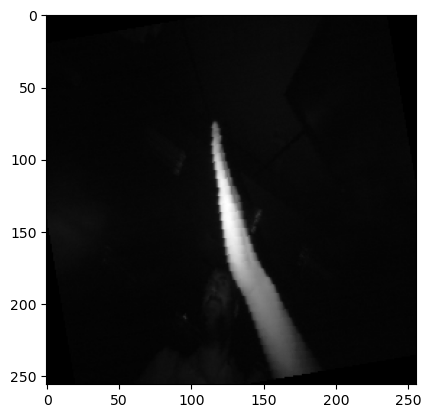

In [9]:
for img, lbl in train_loader:
    print(img.shape)
    print(lbl[0])
    plt.imshow(img[0].permute(1, 2, 0)[:,:,0], cmap='gray')
    break

Resnet

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
!pip install torchsummary

In [12]:
from torchsummary import summary
from torchvision import models

In [13]:
resnet50 = models.resnet50(pretrained=True)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [14]:
for param in list(resnet50.parameters())[:]:
  param.requires_grad = False

In [15]:
resnet50.fc = nn.Linear(2048, 10)

In [16]:
summary(resnet50.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [17]:
resnet50 = resnet50.to(device)

In [20]:
params_to_update = []
for name,param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.Adam(params_to_update, lr=0.01)
criterion = nn.CrossEntropyLoss()

In [23]:
epochs = 10
epoch_losses = []

for epoch in range(epochs):
    
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = resnet50(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        
    test_running_loss = 0
    test_epoch_loss = []
    for batch_idx, (data, labels) in enumerate(valid_loader):
        resnet50.eval()
        data = data.to(device)
        labels = labels.to(device)
        
        outputs = resnet50(data)
        loss = F.cross_entropy(outputs, labels)
                
        test_running_loss += loss.item()
        test_epoch_loss.append(loss.item())
        
        
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss), 'test loss:', np.mean(test_epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 1, loss:  0.6042496013565185 test loss: 2.6239038484331707
Epoch 2, loss:  0.2634942091691989 test loss: 4.137598978156914
Epoch 3, loss:  0.21644176859349107 test loss: 3.294226717572814
Epoch 4, loss:  0.20732617692444652 test loss: 2.733431717021593
Epoch 5, loss:  0.2105387158799 test loss: 3.5724440917910893
Epoch 6, loss:  0.22939536076473493 test loss: 2.843027671635413
Epoch 7, loss:  0.20398487885610556 test loss: 4.384673635000238
Epoch 8, loss:  0.17054306745481568 test loss: 3.4763355199277353
Epoch 9, loss:  0.19032285347158392 test loss: 3.0962076445687385
Epoch 10, loss:  0.15174956642501888 test loss: 3.7575970750165206


In [25]:
torch.save(resnet50, './gest_detection_model.pth')

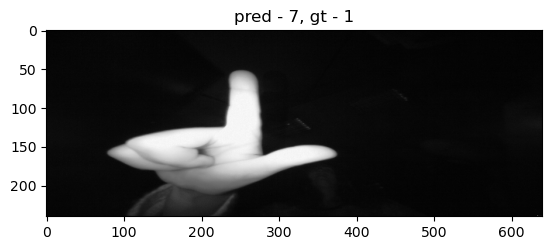

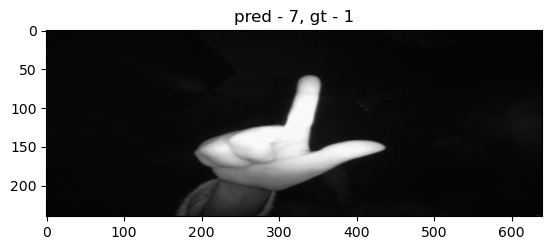

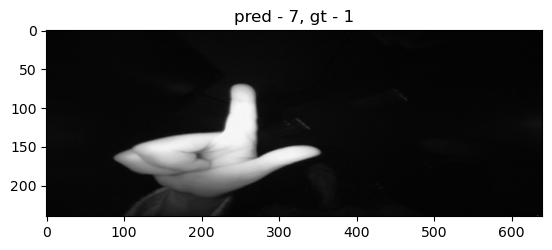

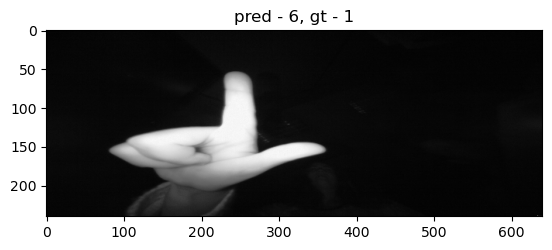

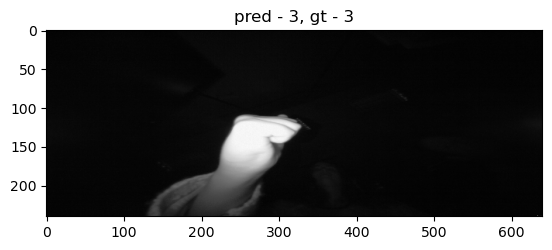

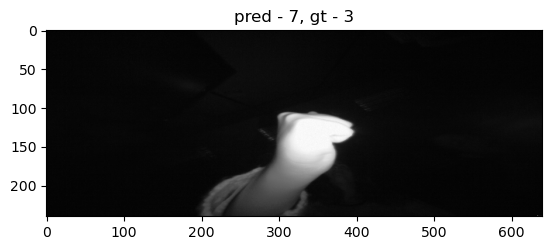

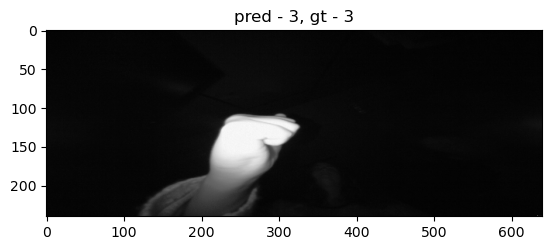

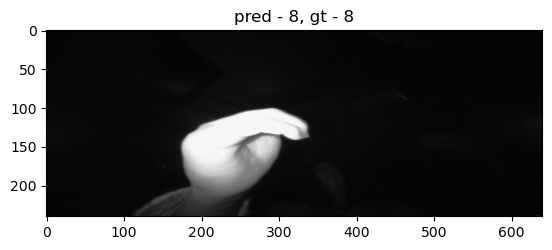

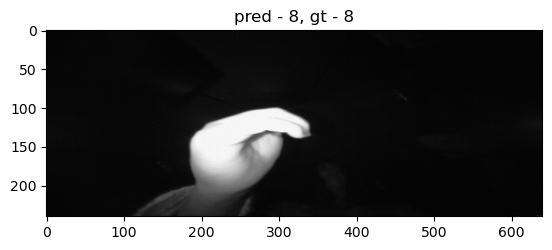

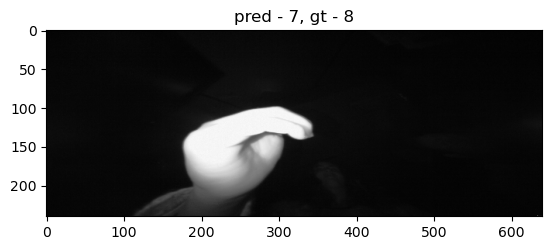

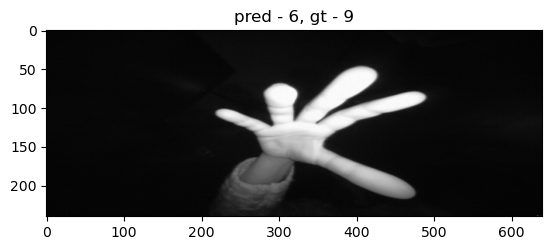

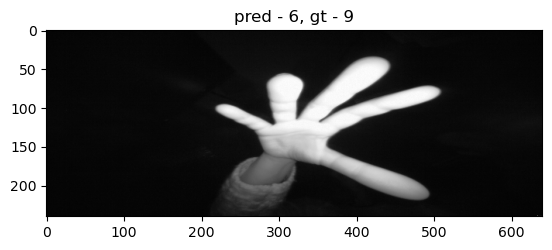

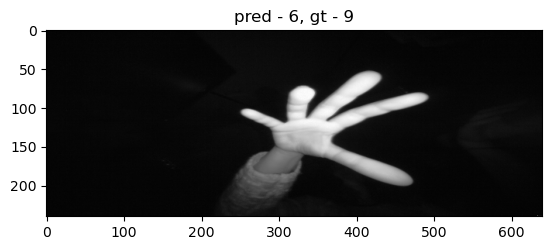

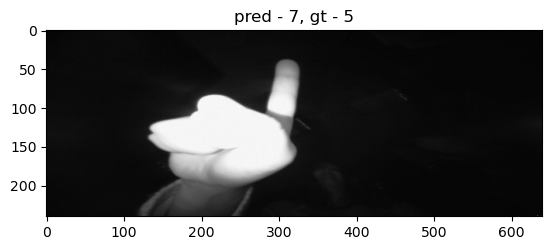

In [35]:
with torch.no_grad():
    for i, data in enumerate(valid_loader, 3):
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = resnet50(images)
        plt.title(f'pred - {outputs[0].argmax()}, gt - {labels[0]}')
        plt.imshow(images[0].cpu().permute(1, 2, 0), cmap='gray')
        plt.show()
        if i>15:
            break